In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import d2l_torch as d2l
import cnn_base as base
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil
from torchvision.datasets import ImageFolder
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
import time
from matplotlib import pyplot as plt
import math
import torch.nn.functional as F

C:\Users\rongjoker\anaconda3\envs\pandas\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ['TORCH_USE_CUDA_DSA']='1'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
data_dir = '../data/kaggle_leaves/classify-leaves/'
batch_size = 128
learning_rate = 1e-4

## 创建划分好的训练集和测试集、数据增强

In [4]:
# # 创建划分好的训练集和测试集
h_flip = transforms.RandomHorizontalFlip(p=0.5)
v_flip = transforms.RandomVerticalFlip(p=0.5)
shape_aug = transforms.RandomResizedCrop((224, 224), scale=(0.1, 1), ratio=(0.5, 2))
brightness_aug = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0)
train_augs = transforms.Compose([h_flip, v_flip])  # 图像增广
train_data_trans = transforms.Compose([transforms.Resize(224),
                                       train_augs,
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_trans = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [5]:
train_data = ImageFolder(os.path.join(data_dir, 'train_image'),
                         transform=train_data_trans, target_transform=None)
test_data = ImageFolder(os.path.join(data_dir, 'test_image'),
                        transform=test_data_trans, target_transform=None)

In [6]:
# 将ImageFolder的映射关系存到csv
id_code = pd.DataFrame(list(train_data.class_to_idx.items()),
                       columns=['label', 'id'])
id_code.to_csv(os.path.join(data_dir, 'id_code.csv'), index=False)

In [7]:
# train_data.class_to_idx.items()

In [8]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [9]:
print('Train_data:')
print('Number of train_dataloader:\t', len(train_dataloader))  # 显示batch的数量
print('Number of train_dataset:\t', len(train_dataloader.dataset))  # 显示训练集样本总数量
print('Test_data:')
print('Number of test_dataloader:\t', len(test_dataloader))  # 显示batch的数量
print('Number of test_dataset:\t', len(test_dataloader.dataset))  # 显示测试集样本总数量
# 每个batch的数据形状
train_X, train_y = next(iter(train_dataloader))
print('Shape:')
print('The shape of train_features in a batch run:\t', train_X.shape)
print('The shape of train_labels in a batch run:\t', train_y.shape, '\n')

Train_data:
Number of train_dataloader:	 101
Number of train_dataset:	 12847
Test_data:
Number of test_dataloader:	 44
Number of test_dataset:	 5506
Shape:
The shape of train_features in a batch run:	 torch.Size([128, 3, 224, 224])
The shape of train_labels in a batch run:	 torch.Size([128]) 



## 定义模型、损失函数、优化器，并执行训练

<font color='red'> </font>

<font color='red'> 定义训练函数
之前的模板中，采用了d2l中第3章定义的训练函数（已改为GPU计算）<br><br>
本模板中，改用为d2l中第6章定义的训练函数，主要区别包括：<br>
1.d2l包中的训练计时功能，能够反映程序运行的时间<br>
2.增加了batch级的绘图<br>
3.每个Epoch都会将迭代报告存储至相应的csv<br>
4.训练结束后会保存模型<br>
5.每个Epoch都会将当前模型保存至新建的model_params_epoch文件夹中（训练函数中，默认被注释，占用硬盘空间）</font>

In [10]:
# 参考The Fashion-MNIST dataset.
class LeavesTrainDataSet(d2l.DataModule):
    def __init__(self, train_dl, test_dl):
        super().__init__()
        self.save_hyperparameters()
        self.train_loader = train_dl
        self.val_loader = test_dl

    def get_dataloader(self, train):
        return self.train_loader if train else self.val_loader

In [11]:
def resnet_train(epoch=10, num_classes = 176):
    # 10 epoch acc: tensor(0.9375, device='cuda:0')
    # base.ResNet18().layer_summary((1, 3, 224, 224))
    model = base.ResNet18(lr=learning_rate, num_classes=num_classes)
    trainer = d2l.Trainer(max_epochs=epoch, num_gpus=1)
    # train_dataloader, test_dataloader = get_train_dataset()
    data = LeavesTrainDataSet(train_dataloader, test_dataloader)
    print('type', type(data.train_dataloader()))
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model, data)
    torch.save(model.state_dict(), 'model/leaves_resnet_jupyter.pth')

In [12]:
def train_concise_main(net, train_iter, valid_iter,loss, num_epochs, lr, wd, lr_period,
          lr_decay):
    # optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
    #                           weight_decay=wd)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = net.to(d2l.try_gpu())
    # net = net.to('cpu')
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, optimizer, d2l.try_all_gpus())
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(d2l.try_all_gpus())}')

<font color='red'>定义模型、损失函数、优化器，并执行训练</font>

In [13]:
# # # 定义超参数
# learning_rate = 1e-4
# batch_size = 128
# num_epochs = 300
# weight_decay = 1e-3

In [14]:
def train_concise():
    base.ResNet18().layer_summary((1, 3, 224, 224))
    learning_rate = 1e-4
    # model = base.ResNet18(lr=learning_rate, num_classes=176)
    model =torchvision.models.resnet18(num_classes=176)
    print(d2l.try_all_gpus())
    # print(model)
    loss = nn.CrossEntropyLoss(reduction='none')
    wd ,lr_period, lr_decay =  5e-4, 4, 0.9
    # # 定义优化器
    # 实例化SGD实例
    # # 执行训练
    print(f'-------------------------------\n'
          f'Train model\n'
          f'-------------------------------')
    print('Start time:', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))  # 打印按指定格式排版的时间
    train_concise_main(model, train_dataloader, test_dataloader,loss, 10, learning_rate, wd ,lr_period, lr_decay)
    print('End time:', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))  # 打印按指定格式排版的时间
    torch.save(model.state_dict(), 'model/leaves_resnet_jupyter.pth')


In [15]:
def accuracy(y_hat, y):
    return (y_hat.argmax(1) == y).sum()

In [16]:
def get_net():
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet50(pretrained=True)  # 使用了resnet50的预训练模型
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 512), nn.ReLU(),  # 在后面输出层中，又增加了几层，目的是维度降到类别数
                                            nn.Linear(512, 256), nn.ReLU(),
                                            nn.Linear(256, 176))  # 树叶分类有176类
    finetune_net = finetune_net.to('cuda:0')  # 将模型送入gpu
    for param in finetune_net.features.parameters():  # 固定住预训练模型中的参数，只调节我们新加的几个层的参数
        param.requires_grad = False
    return finetune_net

In [17]:
train_l,train_a,test_a = 0,0,0

In [18]:

def train_baba(net, train_iter, test_iter, num_epochs, lr):
    model_path = 'model/leaves_resnet_jupyter_baba_%s.pth'% (num_epochs)
    print('model_path:',model_path)
    net =net.to('cuda:0')
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train_loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss_tot, train_acc_tot, train_tot = 0, 0, 0
        test_acc_tot, test_tot = 0, 0
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to('cuda:0'), y.to('cuda:0')
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_loss_tot += l * X.shape[0]
                train_acc_tot += accuracy(y_hat, y)
                train_tot += X.shape[0]
        net.eval()
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to('cuda:0'), y.to('cuda:0')
                test_acc_tot += accuracy(net(X), y)
                test_tot += X.shape[0]
        train_loss = train_loss_tot / train_tot
        train_acc = train_acc_tot / train_tot
        test_acc = test_acc_tot / test_tot
        animator.add(epoch + 1, (train_loss.cpu(), train_acc.cpu(), test_acc.cpu()))
        train_l = train_loss
        train_a = train_acc
        test_a = test_acc
    torch.save(net.state_dict(), model_path)

In [19]:
def infer(pred_iter):
    learning_rate = 1e-4
    model = base.ResNet18(lr=learning_rate, num_classes=176)
    model.load_state_dict(torch.load('model/leaves_resnet_jupyter.pth'))
    model = model.to(try_gpu())
    model.eval()  # 设置模型为推理模式
    prediction = []
    for index, X in enumerate(pred_iter):
        X = X.to('cuda:0')
        prediction.extend(train_labels_header[net(X).argmax(1).cpu()])
    test_data['label'] = prediction
    test_data.to_csv(os.path.join(data_dir, 'submission.csv'), index=None)

In [20]:
# train_concise()
# resnet_train(epoch=100, num_classes = 176)


train_loss: 0 	train_acc 0 	test_acc 0


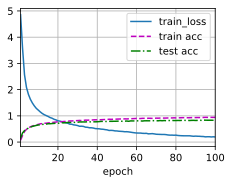

In [21]:
# net = torchvision.models.resnet18(num_classes=176)
train_baba(net=get_net(), train_iter=train_dataloader, test_iter=test_dataloader,num_epochs=100, lr=learning_rate)
print('train_loss:', train_l, '\ttrain_acc', train_a, '\ttest_acc', test_a)

In [22]:
# test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'))
# pred_images = test_data.iloc[:, 0].values
# pred_iter = load_data(pred_images, None, 256, train=False)

In [23]:
model_name = 'model/leaves_resnet_jupyter_%s.pth' % (30)
model_name

'model/leaves_resnet_jupyter_30.pth'